Image credit: [Artificial Neural Networks: Some Misconceptions (Part 3)](https://dzone.com/articles/artificial-neural-networks-some-misconceptions-par-1)

Python source: [451-blog/adam.py at main · doabell/451-blog](https://github.com/doabell/451-blog/blob/main/posts/adam/adam.py)

Instructions can be found at [Optimization with Adam](https://middlebury-csci-0451.github.io/CSCI-0451/assignments/blog-posts/blog-post-adam.html).

## Implementation
The Python source file implements the **Adam** algorithm for Logistic Regression.

Here is Page 2 of [the original paper](https://arxiv.org/pdf/1412.6980.pdf), with line numbers that are referenced in the source file:

![Algorithm 1 from Adam](1412.6980.jpg){fig-alt="Code for Algorithm 1 from the Adam paper."}

## Basic experiments
We compare the performance of Adam with previous algorithms implemented in [Optimization for Logistic Regression](https://doabell.github.io/451-blog/posts/logistic-regression/).

Here is a generated dataset:

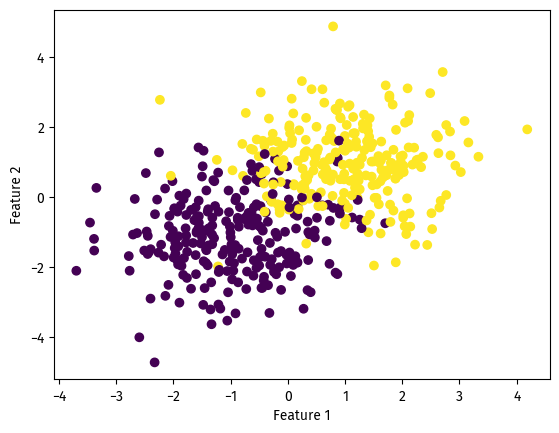

In [61]:
# Data
import numpy as np
from adam import LogisticRegression
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
from matplotlib import font_manager
font_manager.fontManager.addfont("C:\Windows\Fonts\FiraSans-Regular.ttf")
plt.rcParams["font.family"] = "Fira Sans"
np.seterr(all='ignore')
np.random.seed(283)

# make the data
p_features = 3
X, y = make_blobs(
    n_samples=500, n_features=p_features - 1, centers=[(-1, -1), (1, 1)]
)

fig = plt.scatter(X[:, 0], X[:, 1], c=y)
xlab = plt.xlabel("Feature 1")
ylab = plt.ylabel("Feature 2")


### Time

We first examine the runtime and number of epochs for optimization with Adam.

Visualization code adapted from [blog post instructions](https://middlebury-csci-0451.github.io/CSCI-0451/assignments/blog-posts/blog-post-optimization.html#illustration).

In [2]:
max_epochs = 100000
alpha = 0.001

LR_base = LogisticRegression()
LR_sg = LogisticRegression()
LR_sgm = LogisticRegression()
LR_adam = LogisticRegression()

In [3]:
%%timeit
LR_base.fit(X, y, alpha=alpha, max_epochs=max_epochs)

2.08 s ± 206 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
%%timeit
LR_sg.fit_stochastic(
    X, y,
    max_epochs=max_epochs,
    momentum=False,
    batch_size=10,
    alpha=alpha
)

1.71 s ± 59.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
%%timeit
LR_sgm.fit_stochastic(
    X, y,
    max_epochs=max_epochs,
    momentum=True,
    batch_size=10,
    alpha=alpha
)

1.73 s ± 46.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%%timeit
LR_adam.fit_adam(
    X, y,
    alpha=alpha,
    max_epochs=max_epochs
)

706 ms ± 106 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


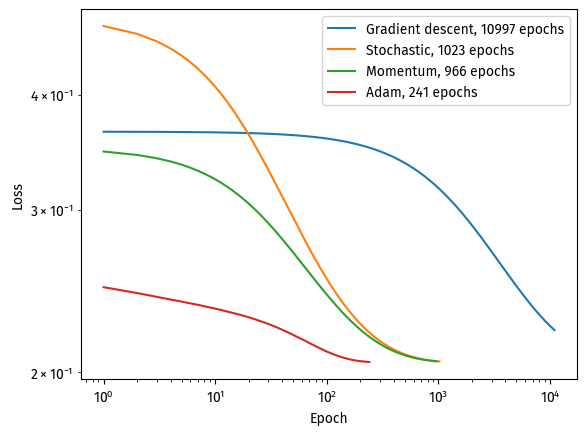

In [7]:
plt.plot(
    np.arange(len(LR_base.loss_history)) + 1,
    LR_base.loss_history,
    label=f"Gradient descent, {len(LR_base.loss_history)} epochs"
)

plt.plot(
    np.arange(len(LR_sg.loss_history)) + 1,
    LR_sg.loss_history,
    label=f"Stochastic, {len(LR_sg.loss_history)} epochs"
)

plt.plot(
    np.arange(len(LR_sgm.loss_history)) + 1,
    LR_sgm.loss_history,
    label=f"Momentum, {len(LR_sgm.loss_history)} epochs"
)

plt.plot(
    np.arange(len(LR_adam.loss_history)) + 1,
    LR_adam.loss_history,
    label=f"Adam, {len(LR_adam.loss_history)} epochs"
)

plt.loglog()

legend = plt.legend(loc="upper right")
xlab = plt.xlabel("Epoch")
ylab = plt.ylabel("Loss")


#### Epochs

We observe that Adam is the fastest, converging in only 241 epochs.

This is much faster than stochastic gradient descent, with or without the momentum method.
Both of these converged in around 1000 epochs.

Normal gradient descent is the slowest, failing to converge after 10000 epochs.

#### Wall time

Using the [`%%timeit`](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit) magic command from IPython:

- Adam has the fastest runtime of 616ms.
- Stocastic gradient descent, with or without momentum, took around 1.76s.
- "Plain" gradient descent took 1.98s, although 1.76s is within 1.5 standard deviations.

### Learning rate
The [learning rate](https://developers.google.com/machine-learning/crash-course/reducing-loss/learning-rate) determines how much we move along the gradient.

When the learning rate is too large, gradient descent will exceed the optimal minimum;
when it is too small, gradient descent will take longer to reach the optimal minimum.

We loop our Adam implementation through multiple learning rates:

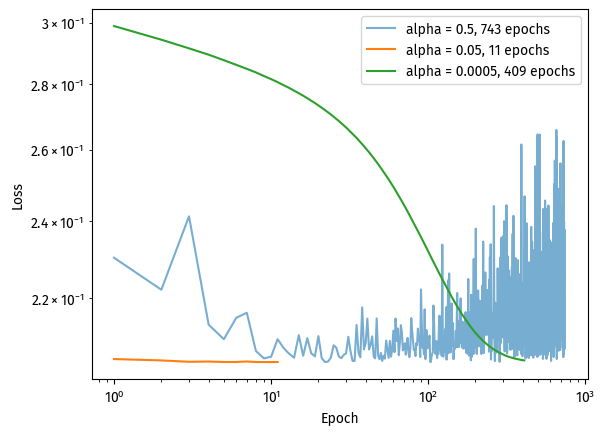

In [8]:
alphas = [0.5, 0.05, 0.0005]
max_epochs = 1000

for alpha in alphas:
    LR = LogisticRegression()
    LR.fit_adam(
        X, y,
        max_epochs=max_epochs,
        batch_size=10,
        alpha=alpha
    )

    num_steps = len(LR.loss_history)
    plt.plot(
        np.arange(num_steps) + 1, LR.loss_history,
        label=f"alpha = {alpha}, {num_steps} epochs",
        alpha=0.6 if alpha == 0.5 else 1
    )

plt.loglog()

legend = plt.legend()
xlab = plt.xlabel("Epoch")
ylab = plt.ylabel("Loss")

With three different learning rates, we can see a difference in how training loss progressed over time:

- Reasonably small, `alpha = 0.05`: loss decreased quickly, converging in only 11 iterations.
- Too small, `alpha = 0.0005`: loss decreased more smoothly but slowly, converging in 409 iterations.
- Too large, `alpha = 0.5`: loss jumped up and down frequently, converging in 743 iterations.

This shows that indeed, we want a reasonably small learning rate.
Small enough to converge, but not too small that converging becomes too slow.

### Batch size
We look at another hyperparameter, the batch size.

Because we look at each "batch" separately, the size of these batches, might determine the speed of gradient descent.

Using our reasonable learning rate of `alpha = 0.05`:

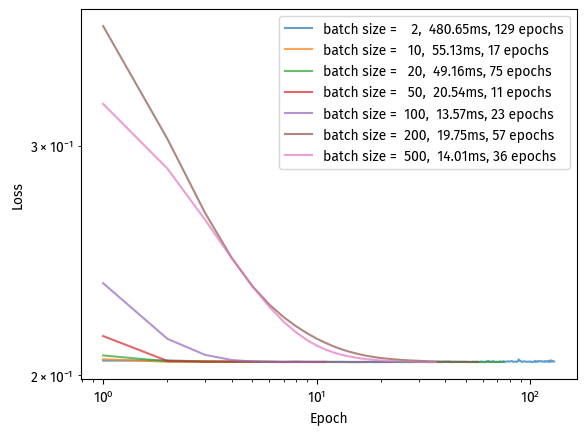

In [9]:
from time import perf_counter
batch_sizes = [2, 10, 20, 50, 100, 200, 500]
repeat = 5

for batch_size in batch_sizes:
    times = []
    for _ in range(repeat):
        LR = LogisticRegression()
        start = perf_counter() * 1000
        LR.fit_adam(
            X, y,
            max_epochs=1000,
            batch_size=batch_size,
            alpha=0.05
        )
        end = perf_counter() * 1000
        times.append(end - start)

    perf = sum(times) / len(times)

    num_steps = len(LR.loss_history)
    plt.plot(
        np.arange(num_steps) + 1, LR.loss_history,
        label=f"batch size = {batch_size:4}, {perf:> 6.2f}ms, {num_steps} epochs",
        alpha=0.7
    )

plt.loglog()

legend = plt.legend()
xlab = plt.xlabel("Epoch")
ylab = plt.ylabel("Loss")


Here, using otherwise identical hyperparameters, we observe that batch size does affect convergence speed and runtime.

A batch size of 2 yielded the most epochs and the longest runtime.

A batch size of 50 converged the fastest, although it is slightly slower than a batch size of 100 and 200, perhaps due to more calculations per loop.

Larger batch sizes took more epochs to converge, while maintaining around the same wall clock time.

In conclusion, a reasonable batch size (in this case, 100) strikes a nice balance between wall clock time and the number of epochs needed to converge.

## Digits
We load the [digits dataset](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits) included with [`scikit-learn`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html).

Because we are predicting binary lables, we choose only the numbers `4` and `9`.
Then, we normalize the X and y labels.
Finally, we perform a train-test split.

In [156]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

digits = load_digits()
X = digits.data
y = digits.target
X = X[np.logical_or(y == 4, y == 9)]
y = y[np.logical_or(y == 4, y == 9)]

X = normalize(X, axis=0)
y = np.where(y == 4, 0, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [157]:
max_epochs = 10000
alpha = 0.001
batch_size = 10

LR_sg = LogisticRegression()
LR_adam = LogisticRegression()

In [158]:
%%timeit -n1 -r1
LR_sg.fit_stochastic(
    X_train, y_train,
    max_epochs=max_epochs,
    momentum=False,
    alpha=alpha,
    batch_size=batch_size
)

13.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [159]:
%%timeit -n1 -r1
LR_adam.fit_adam(
    X_train, y_train,
    alpha=alpha,
    max_epochs=max_epochs,
    batch_size=batch_size
)

16.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


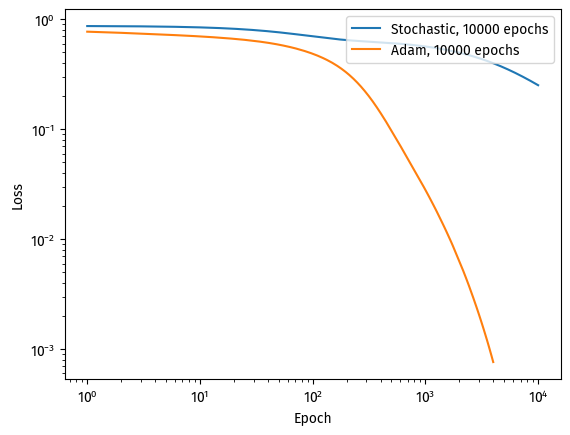

In [160]:
plt.plot(
    np.arange(len(LR_sg.loss_history)) + 1,
    LR_sg.loss_history,
    label=f"Stochastic, {len(LR_sg.loss_history)} epochs"
)

plt.plot(
    np.arange(len(LR_adam.loss_history)) + 1,
    LR_adam.loss_history,
    label=f"Adam, {len(LR_adam.loss_history)} epochs"
)

plt.loglog()

legend = plt.legend(loc="upper right")
xlab = plt.xlabel("Epoch")
ylab = plt.ylabel("Loss")